In [1]:
import math
import glob
import os
from tqdm import tqdm,trange
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Dict



edited:https://github.com/j-sripad/mulitresunet-pytorch/blob/main/multiresunet.py

In [2]:


class Multiresblock(nn.Module):
  def __init__(self,input_features : int, corresponding_unet_filters : int ,alpha : float =2.5)->None:
    """
        MultiResblock

        Arguments:
          x - input layer
          corresponding_unet_filters - Unet filters for the same stage
          alpha - 1.67 - factor used in the paper to dervie number of filters for multiresunet filters from Unet filters

        Returns - None

    """ 
    super().__init__()
    self.corresponding_unet_filters = corresponding_unet_filters
    self.alpha = alpha
    self.W = corresponding_unet_filters * alpha
    self.conv2d_bn_1x1 = Conv1d_batchnorm(input_features=input_features,num_of_filters = int(self.W*0.167)+int(self.W*0.333)+int(self.W*0.5),
    kernel_size = 1,activation='None',padding = 0)

    self.conv2d_bn_3x3 = Conv1d_batchnorm(input_features=input_features,num_of_filters = int(self.W*0.167),
    kernel_size = 3,activation='relu',padding = 1)
    self.conv2d_bn_5x5 = Conv1d_batchnorm(input_features=int(self.W*0.167),num_of_filters = int(self.W*0.333),
    kernel_size = 3,activation='relu',padding = 1)
    self.conv2d_bn_7x7 = Conv1d_batchnorm(input_features=int(self.W*0.333),num_of_filters = int(self.W*0.5),
    kernel_size = 3,activation='relu',padding = 1)
    self.batch_norm1 = nn.BatchNorm1d(int(self.W*0.5)+int(self.W*0.167)+int(self.W*0.333) ,affine=False)

  def forward(self,x: torch.Tensor)->torch.Tensor:

    temp = self.conv2d_bn_1x1(x)
    a = self.conv2d_bn_3x3(x)
    b = self.conv2d_bn_5x5(a)
    c = self.conv2d_bn_7x7(b)
    x = torch.cat([a,b,c],axis=1)
    x = self.batch_norm1(x)
    x = x +  temp
    x = self.batch_norm1(x)
    return x

class Conv1d_batchnorm(nn.Module):
  def __init__(self,input_features : int,num_of_filters : int ,kernel_size : int = 2,stride : int = 1, activation : str = 'relu',padding  : int= 0)->None:
    """
    Arguments:
      x - input layer
      num_of_filters - no. of filter outputs
      filters - shape of the filters to be used
      stride - stride dimension 
      activation -activation function to be used

    Returns - None
    """
    super().__init__()
    self.activation = activation
    self.conv1 = nn.Conv1d(in_channels=input_features,out_channels=num_of_filters,kernel_size=kernel_size,stride=stride,padding = padding)
    self.batchnorm = nn.BatchNorm1d(num_of_filters,affine=False)
    nn.init.kaiming_uniform_(self.conv1.weight.data)
    nn.init.zeros_(self.conv1.bias.data)
    print(self.conv1.weight.data)
  def forward(self,x : torch.Tensor)->torch.Tensor:
    x = self.conv1(x)
    x = self.batchnorm(x)
    if self.activation == 'relu':
      return F.relu(x)
    else:
      return x


class Respath(nn.Module):
  def __init__(self,input_features : int,filters : int,respath_length : int)->None:
    """
    Arguments:
    input_features - input layer filters
    filters - output channels
    respath_length - length of the Respath
    
    Returns - None
    """
    super().__init__()
    self.filters = filters
    self.respath_length = respath_length
    self.conv2d_bn_1x1 = Conv1d_batchnorm(input_features=input_features,num_of_filters = self.filters,
    kernel_size = 1,activation='None',padding = 0)
    self.conv2d_bn_3x3 = Conv1d_batchnorm(input_features=input_features,num_of_filters = self.filters,
    kernel_size =3,activation='relu',padding = 1)
    self.conv2d_bn_1x1_common = Conv1d_batchnorm(input_features=self.filters,num_of_filters = self.filters,
    kernel_size =1,activation='None',padding = 0)
    self.conv2d_bn_3x3_common = Conv1d_batchnorm(input_features=self.filters,num_of_filters = self.filters,
    kernel_size =3,activation='relu',padding = 1)
    self.batch_norm1 = nn.BatchNorm1d(filters,affine=False)
    
  def forward(self,x : torch.Tensor)->torch.Tensor:
    shortcut = self.conv2d_bn_1x1(x)
    x = self.conv2d_bn_3x3(x)
    x = x + shortcut    
    x = F.relu(x)
    x = self.batch_norm1(x)
    if self.respath_length>1:
      for i in range(self.respath_length):
        shortcut = self.conv2d_bn_1x1_common(x)
        x = self.conv2d_bn_3x3_common(x)
        x = x +  shortcut
        x = F.relu(x)
        x = self.batch_norm1(x)
      return x
    else:
      return x

class MultiResUnet(nn.Module):
  def __init__(self,channels : int,filters : int =32,nclasses : int =1)->None:

    """
    Arguments:
    channels - input image channels
    filters - filters to begin with (Unet)
    nclasses - number of classes

    Returns - None
    """
    super().__init__()
    # self.alpha = 1.67
    self.alpha = 2.5
    self.filters = filters
    self.nclasses = nclasses
    self.multiresblock1 = Multiresblock(input_features=channels,corresponding_unet_filters=self.filters)
    self.pool1 =  nn.MaxPool1d(2,stride= 2)
    self.in_filters1 = int(self.filters*self.alpha* 0.5)+int(self.filters*self.alpha*0.167)+int(self.filters*self.alpha*0.333)
    self.respath1 = Respath(input_features=self.in_filters1 ,filters=self.filters,respath_length=4)
    self.multiresblock2 = Multiresblock(input_features= self.in_filters1,corresponding_unet_filters=self.filters*2)
    self.pool2 =  nn.MaxPool1d(2, 2)
    self.in_filters2 = int(self.filters*2*self.alpha* 0.5)+int(self.filters*2*self.alpha*0.167)+int(self.filters*2*self.alpha*0.333)
    self.respath2 = Respath(input_features=self.in_filters2,filters=self.filters*2,respath_length=3)
    self.multiresblock3 = Multiresblock(input_features= self.in_filters2,corresponding_unet_filters=self.filters*4)
    self.pool3 =  nn.MaxPool1d(2, 2)
    self.in_filters3 = int(self.filters*4*self.alpha* 0.5)+int(self.filters*4*self.alpha*0.167)+int(self.filters*4*self.alpha*0.333)
    self.respath3 = Respath(input_features=self.in_filters3,filters=self.filters*4,respath_length=2)
    self.multiresblock4 = Multiresblock(input_features= self.in_filters3,corresponding_unet_filters=self.filters*8)
    self.pool4 =  nn.MaxPool1d(2, 2)
    self.in_filters4 = int(self.filters*8*self.alpha* 0.5)+int(self.filters*8*self.alpha*0.167)+int(self.filters*8*self.alpha*0.333)
    self.respath4 = Respath(input_features=self.in_filters4,filters=self.filters*8,respath_length=1)
    self.multiresblock5 = Multiresblock(input_features= self.in_filters4,corresponding_unet_filters=self.filters*16)
    self.in_filters5 = int(self.filters*16*self.alpha* 0.5)+int(self.filters*16*self.alpha*0.167)+int(self.filters*16*self.alpha*0.333)
     
    #Decoder path
    self.upsample6 = nn.ConvTranspose1d(in_channels=self.in_filters5,out_channels=self.filters*8,kernel_size=2,stride=2,padding = 0)  
    self.concat_filters1 = self.filters*8+self.filters*8
    self.multiresblock6 = Multiresblock(input_features=self.concat_filters1,corresponding_unet_filters=self.filters*8)
    self.in_filters6 = int(self.filters*8*self.alpha* 0.5)+int(self.filters*8*self.alpha*0.167)+int(self.filters*8*self.alpha*0.333)
    self.upsample7 = nn.ConvTranspose1d(in_channels=self.in_filters6,out_channels=self.filters*4,kernel_size=2,stride=2,padding = 0)  
    self.concat_filters2 = self.filters*4+self.filters*4
    self.multiresblock7 = Multiresblock(input_features=self.concat_filters2,corresponding_unet_filters=self.filters*4)
    self.in_filters7 = int(self.filters*4*self.alpha* 0.5)+int(self.filters*4*self.alpha*0.167)+int(self.filters*4*self.alpha*0.333)
    self.upsample8 = nn.ConvTranspose1d(in_channels=self.in_filters7,out_channels=self.filters*2,kernel_size=2,stride=2,padding = 0)  
    self.concat_filters3 = self.filters*2+self.filters*2
    self.multiresblock8 = Multiresblock(input_features=self.concat_filters3,corresponding_unet_filters=self.filters*2)
    self.in_filters8 = int(self.filters*2*self.alpha* 0.5)+int(self.filters*2*self.alpha*0.167)+int(self.filters*2*self.alpha*0.333)
    self.upsample9 = nn.ConvTranspose1d(in_channels=self.in_filters8,out_channels=self.filters,kernel_size=2,stride=2,padding = 0)  
    self.concat_filters4 = self.filters+self.filters
    self.multiresblock9 = Multiresblock(input_features=self.concat_filters4,corresponding_unet_filters=self.filters)
    self.in_filters9 = int(self.filters*self.alpha* 0.5)+int(self.filters*self.alpha*0.167)+int(self.filters*self.alpha*0.333)
    self.conv_final = Conv1d_batchnorm(input_features=self.in_filters9,num_of_filters = self.nclasses,
    kernel_size = 1,activation='None')
    
    

  def forward(self,x : torch.Tensor)->torch.Tensor:
    x_multires1 = self.multiresblock1(x)
    x_pool1 = self.pool1(x_multires1)
    x_multires1 = self.respath1(x_multires1)
    x_multires2 = self.multiresblock2(x_pool1)
    x_pool2 = self.pool2(x_multires2)
    x_multires2 = self.respath2(x_multires2)
    x_multires3 = self.multiresblock3(x_pool2)
    x_pool3 = self.pool3(x_multires3)
    x_multires3 = self.respath3(x_multires3)
    x_multires4 = self.multiresblock4(x_pool3)
    x_pool4 = self.pool4(x_multires4)
    x_multires4 = self.respath4(x_multires4)
    x_multires5 = self.multiresblock5(x_pool4)
    up6 = torch.cat([self.upsample6(x_multires5),x_multires4],axis=1)
    x_multires6 = self.multiresblock6(up6)
    up7 = torch.cat([self.upsample7(x_multires6),x_multires3],axis=1)
    x_multires7 = self.multiresblock7(up7)
    up8 = torch.cat([self.upsample8(x_multires7),x_multires2],axis=1)
    x_multires8 = self.multiresblock8(up8)
    up9 = torch.cat([self.upsample9(x_multires8),x_multires1],axis=1)
    x_multires9 = self.multiresblock9(up9)
    conv_final_layer =  self.conv_final(x_multires9)
    # print(torch.mean(x_multires1).item(),torch.mean(x_multires2).item(),torch.mean(x_multires3).item(),torch.mean(x_multires4).item(),torch.mean(x_multires5).item(),torch.mean(x_multires6).item(),torch.mean(x_multires7).item(),torch.mean(x_multires8).item(),torch.mean(x_multires9).item(),)
    return conv_final_layer


### Dataset

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, phase,data_len=-1, loader=None):
        self.data_root = data_root
        self.load_npys(phase)
        print("data prepared:" ,self.x.shape)
    def load_npys(self,phase):
    
        self.x = np.load(self.data_root+"\\"+phase+"\\Out.npy").astype(np.float32)
        self.y = np.load(self.data_root+"\\"+phase+"\\GT.npy").astype(np.float32)
        print(type(self.x[0]))
    def __getitem__(self, index):
        # return torch.from_numpy(self.x[index].reshape(1,-1)),torch.from_numpy(self.y[index].reshape(1,-1))
        return self.x[index].reshape(1,-1),self.y[index].reshape(1,-1)
    def __len__(self):
        return self.x.shape[0]

### EarlyStopping(https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py)

In [4]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model,epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model,epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model,epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model,epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path(t=epoch))
        self.val_loss_min = val_loss

### get training data from repos/pallette/experiments

In [5]:
def save_data(type='GT',):
    data_path = r"..\repos\Palette\experiments\test_ppg2abp_1DBP_v2_240109_052308\results\test\0"
    save_dir = r"..\data\processed\P_output_1219"
    train = 481115
    val = 538456
    files = glob.glob(f"{data_path}\{type}_*.npy")
    data = []
    for i in trange(len(files)):
        data.append(np.load(files[i]))
    data = np.concatenate(data)
    print(type,' shape:',data.shape)
    os.makedirs(save_dir+"//train",exist_ok=True)
    os.makedirs(save_dir+"//validate",exist_ok=True)
    os.makedirs(save_dir+"//test",exist_ok=True)
    np.save(os.path.join(save_dir,"train",f"{type}.npy"),data[:train])
    np.save(os.path.join(save_dir,"validate",f"{type}.npy"),data[train:val])
    np.save(os.path.join(save_dir,"test",f"{type}.npy"),data[val:])

In [6]:

# save_data("GT")

# save_data("Out")
# save_data("Process")
# 57341
# test = 105821


In [7]:
# shapes = []
# for i in range(12):
#     data = np.load(r"..\data\processed\BP_npy\1219\p00\p0000"+f"{i:02d}.npy")
#     shapes.append(data.shape[0])
# del data
# print(shapes)
# print(np.sum(shapes[0:9]),shapes[9],np.sum(shapes[10:12]),np.sum(shapes))

### Train and Validate function

In [13]:
from torch.autograd import Variable
import wandb
import time
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


# def train(dataloader, model, loss_fn,mae_fn, optimizer):
def train(dataloader, model,lr=0.0001):
    loss_fn = nn.MSELoss()
    loss_mae = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    size = len(dataloader.dataset)
    mse_sum=0
    mae_sum=0
    total=0
    with tqdm(total=len(dataloader),unit="batch") as pbar:
        # with torch.autograd.set_detect_anomaly(True):
        for batch, (X, y) in enumerate(dataloader):
            # print(X.shape,y.shape)
            X, y = Variable(X).to(device), Variable(y).to(device)
            optimizer.zero_grad()
            # print(X.shape,y.shape)
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            mae = loss_mae(pred,y)
            # Backpropagation
            total+=X.size(0)
            mse_sum+=loss*X.size(0) 
            mae_sum+=mae*X.size(0) 
            running_mae=mae_sum/total
            running_mse=mse_sum/total
            loss.backward()
            # print(X.grad)
            optimizer.step()
            metrics = {"loss":loss.item(),"mae":mae.item(),"loss(MSE)":running_mse.item(),"MAE":running_mae.item(),"Total":total}
            if batch < 100:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)
            # if batch < 50:
                # wandb.log(metrics)
                # torch.save(model.state_dict(),"./wandb/weights.pth")
                # artifact = wandb.Artifact('model-weights',type='weights')
                # artifact.add_file("./wandb/weights.pth")
                # wandb.log_artifact(artifact)
                # time.sleep(10)
            pbar.set_postfix(metrics)
            pbar.update(1)

In [9]:
def test(dataloader, model, loss_fn,mae_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss= 0
    test_mae=0
    with torch.no_grad():
        for X, y in dataloader:

            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_mae += mae_fn(pred, y).item()
    test_loss /= num_batches
    test_mae /= num_batches
    print(f"Test Error: \nMSE: {test_loss:>8f} \nMAE: {test_mae:>8f} \n")
    return test_loss

### Training code

In [10]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ax600002. Use `wandb login --relogin` to force relogin


True

In [14]:
from torch.autograd import Variable
epochs = 100
lr = 0.0001
wandb.init(
    # set the wandb project where this run will be logged
    project="MultiResUnet",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "MultiResUNet",
    "dataset": "bpdataset",
    "epochs": epochs,
    }
)

save_dir = r"..\data\processed\P_output_1219"
train_dataloader=torch.utils.data.DataLoader(MyDataset(save_dir,"train"),batch_size=32,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(MyDataset(save_dir,"validate"),batch_size=256,shuffle=False)
model = MultiResUnet(1,32,1).to(device)
wandb.watch(model, log_freq=100)
# loss_fn = nn.MSELoss()
# loss_mae = nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
path = os.path.join("..\\refinement\\0109\\{t}.pth")
early_stopping = EarlyStopping(patience=20, verbose=True)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # train(train_dataloader, model, loss_fn,loss_mae, optimizer)
    train(train_dataloader, model)
    val_loss = test(test_dataloader, model, loss_fn,loss_mae)
    early_stopping(val_loss, model,t)

    if early_stopping.early_stop:
        print("Early stopping")
        break
torch.save(model.state_dict(),path(t="latest"))
wandb.finish()

<class 'numpy.ndarray'>
data prepared: (481115, 512)
<class 'numpy.ndarray'>
data prepared: (57341, 512)
tensor([[[-0.5671]],

        [[-0.7236]],

        [[ 1.8191]],

        [[-0.9297]],

        [[ 0.3300]],

        [[-2.1751]],

        [[ 2.1888]],

        [[ 0.6621]],

        [[-0.6228]],

        [[-0.8920]],

        [[-1.3285]],

        [[-1.3781]],

        [[-1.7584]],

        [[-0.8391]],

        [[-1.5009]],

        [[-1.9379]],

        [[-0.0153]],

        [[ 1.3824]],

        [[-0.8976]],

        [[-0.2276]],

        [[-0.3682]],

        [[ 1.0699]],

        [[-2.1352]],

        [[-0.2229]],

        [[ 0.4685]],

        [[ 0.9983]],

        [[ 1.9508]],

        [[-0.7613]],

        [[-0.4210]],

        [[ 1.3776]],

        [[ 1.0505]],

        [[ 0.5894]],

        [[-0.2298]],

        [[ 0.9053]],

        [[-2.2563]],

        [[ 0.0438]],

        [[ 2.4214]],

        [[ 0.9751]],

        [[-1.2914]],

        [[ 0.9861]],

        [[-1.28

  3%|▎         | 376/15035 [00:11<07:09, 34.13batch/s, loss=0.983, mae=0.86, loss(MSE)=0.997, MAE=0.86, Total=12032]  


KeyboardInterrupt: 

In [15]:
wandb.finish()

MAE,▁▁▂▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
Total,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▄▄▃▂▂▂▂▂▂▃▂▂▂▂▂▃▂▂▂▂▂▁▁▂▃▂▂▁▂▁▂▂▂▂▂▁▁
loss(MSE),█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,▁▁▂▃▃▄▃▅▅▅▄▅▇▅▅▇▇▆█▇▇▅▆▆▅▆▆▇▇▇▇▇▆▇▇▇▆▇▆▇
MAE,0.84838
Total,3200
loss,0.98364
loss(MSE),1.0143
mae,0.86259


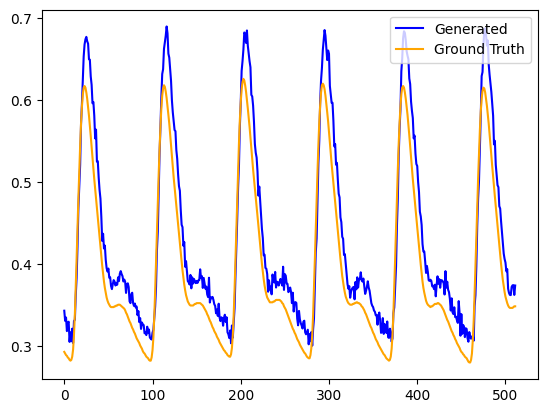

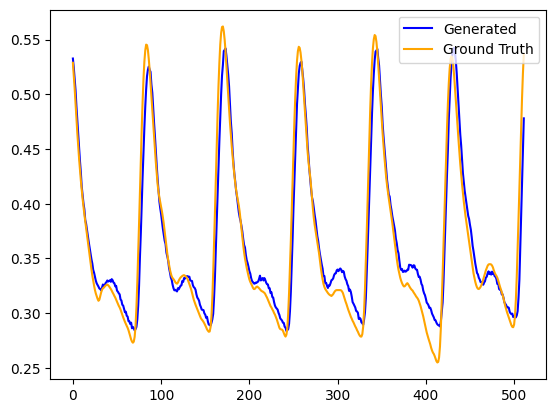

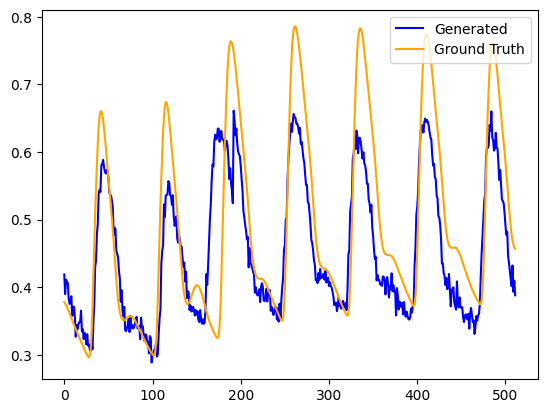

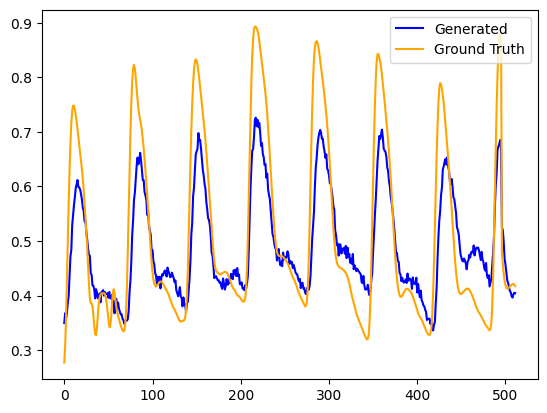

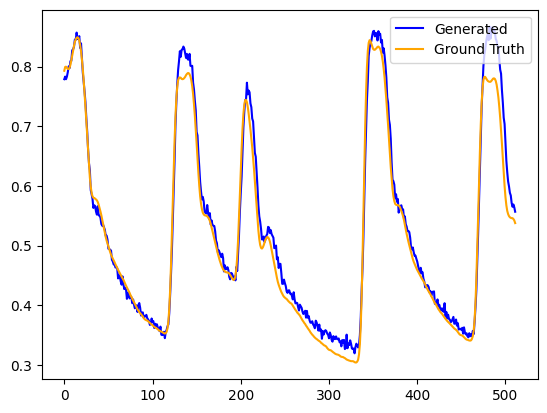

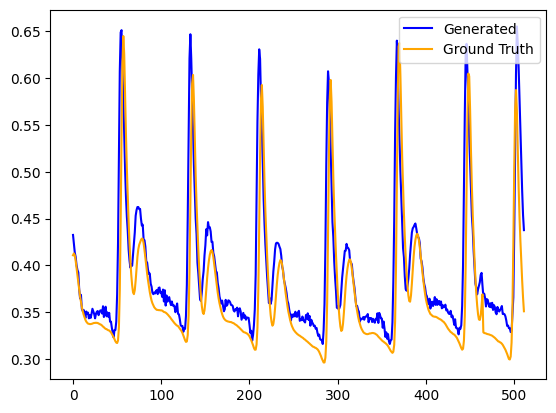

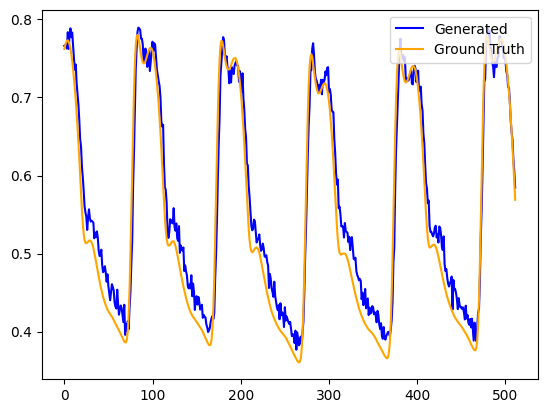

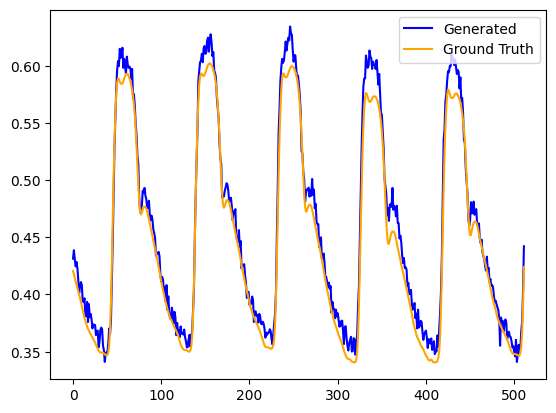

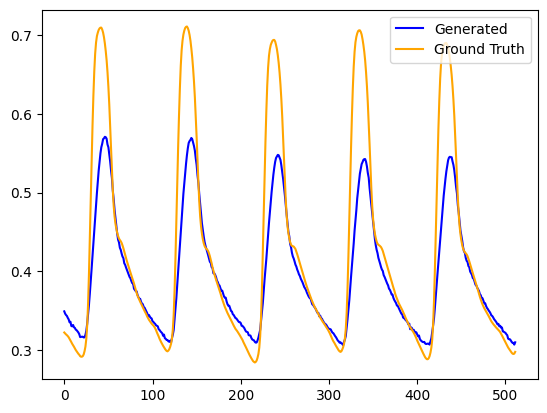

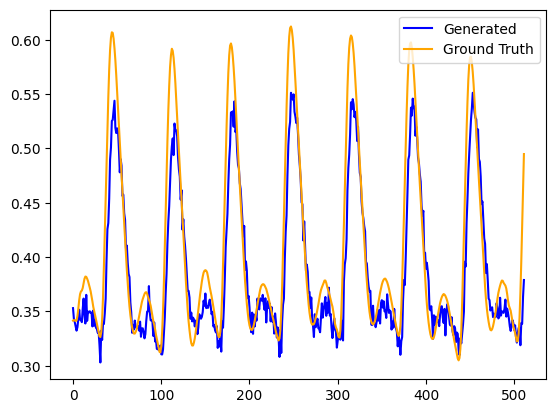

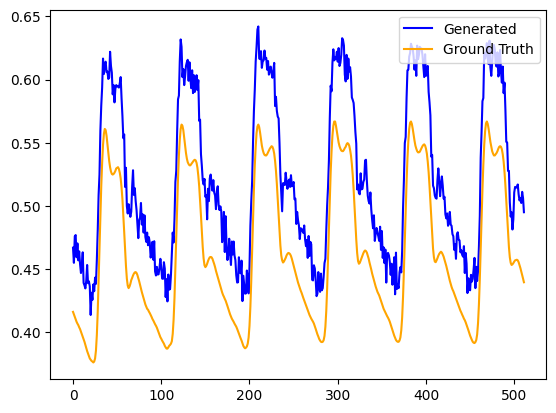

In [ ]:
import matplotlib.pyplot as plt
for i,(X,y) in enumerate(train_dataloader):
    plt.figure()
    plt.plot(X[0].detach().cpu().squeeze(),c='blue',label='Generated')
    plt.plot(y[0].detach().cpu().squeeze(),c='orange',label='Ground Truth')
    plt.legend(loc='upper right')
    if(i==5):
        break

In [ ]:
opt_mod = torch.compile(model)

RuntimeError: Windows not yet supported for torch.compile